In [1]:
import sys
home_dir = "../"
sys.path.append(home_dir)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import matplotlib.ticker as ticker

In [2]:
model_names_dict = {"tapebert":"TAPE-BERT", "proteinbert": "ProteinBERT", "esm2_t33_650M_UR50D":"ESM2", "esm1b_t33_650M_UR50S":"ESM1b", 
                    "prottrans_bert_bfd": "Prottrans-BERT", "prottrans_albert_bfd":"Prottrans-ALBERT", "prottrans_t5_bfd":"Prottrans-T5"}
baseline_model_names_dict = {"hhblits":"HHblits"}
metric_names_dict = {"aurocs":"AUROC", "auprcs":"AUPRC", "hit1s":"Hit@1", "hit10s":"Hit@10"}
ths = [10, 20, 30, 40, 70, 95]
colors_dict = {"aurocs": ["purple", "crimson", "mediumvioletred", "hotpink", "pink", "lavenderblush"],
               "auprcs": ["darkred", "red", "orangered", "darkorange", "goldenrod", "darkkhaki"],
               "hit1s": ["darkolivegreen", "forestgreen", "teal", "cadetblue", "skyblue", "lightblue"],
               "hit10s": ["darkblue", "darkslateblue", "indigo", "darkviolet", "mediumorchid", "plum"]}

In [3]:
def get_models_performance_dicts(data_name, remote_homology_level, results_type, model_names):
    results = {}
    for model_idx, model_name  in enumerate(model_names):
        aurocs, auprcs, hit1s, hit10s = [], [], [], []
        for th in ths:
            results_df = pd.read_csv(home_dir+f"data/{data_name}/{model_name}/{remote_homology_level}/th_{th}/{results_type}_results.tsv", sep="\t")
            mean_perf = results_df[results_df["index"]=="mean"]
            
            auroc, auprc, hit1, hit10 = mean_perf["auroc"].values[0],  mean_perf["auprc"].values[0],  mean_perf["hit1"].values[0],  mean_perf["hit10"].values[0]
            aurocs.append(auroc)
            auprcs.append(auprc)
            hit1s.append(hit1)
            hit10s.append(hit10)
        results[model_name] = {"aurocs": aurocs, "auprcs": auprcs, "hit1s": hit1s, "hit10s":hit10s}
    # break
    return results

# get_models_performance_dicts(model_names_dict.keys())


# setting the plot title to span the plot width
def add_title_spanning_width(ax, title_str):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size="13%", pad=0.04)
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.spines['top'].set_visible(False)
    cax.spines['right'].set_visible(False)
    cax.spines['bottom'].set_visible(False)
    cax.spines['left'].set_visible(False)
    cax.set_facecolor('silver')
    at = AnchoredText(title_str, loc=10, pad=0, borderpad=0,
                    prop=dict(backgroundcolor='silver', size=15, color='black'))
    cax.add_artist(at)

In [4]:
from matplotlib.lines import Line2D
def do_plotting(data_name, remote_homology_level, results_type, metric_name, save_plot=False):
    plt.rcParams['font.size'] = 15
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, height_ratios=[8, 1])
    fig.tight_layout()
    plt.subplots_adjust(hspace=0)

    # setting each subplot background-color, grid, and removing border
    for ax in [ax1, ax2]:
        ax.set(facecolor="gainsboro")
        ax.set_axisbelow(True) # this will show the scatter points above the grid
        ax.grid(True, linestyle="--", c="white")
        for x in ["top", "bottom", "left", "right"]:
            ax.spines[x].set_visible(False)


    # add_title_spanning_width(ax1, "Protein LMs")

    legend_designs, legend_labels = [], []
    for i, color in enumerate(colors_dict[metric_name]):
        legend_designs.append(Line2D([0], [0], color=color, lw=3, marker="o", markersize=10))
        legend_labels.append(f"th={str(ths[i])}")


    models_results = get_models_performance_dicts(data_name, remote_homology_level, results_type, model_names_dict.keys())
    for model_idx, model_name in enumerate(model_names_dict.keys()):
        metrics = models_results[model_name][metric_name]
        # auprcs = models_results[model_name]["auprcs"]
        # hit1s = models_results[model_name]["hit1s"]
        # hit10s = models_results[model_name]["hit10s"]
        ax1.scatter([model_idx]*len(ths), metrics, c= colors_dict['aurocs'], s=60)
        # ax1.legend(legend_designs, legend_labels, loc="lower center", ncols=len(ths)//2, bbox_to_anchor=(0.3, -.98), fontsize=10.5)
    ax1.set_ylim(top=1.0)
    ax1.set_ylabel(metric_names_dict[metric_name], fontsize=20)

    random_baseline_results = get_models_performance_dicts(data_name, remote_homology_level, results_type, ["random"])
    random_metrics = np.mean(random_baseline_results["random"][metric_name])
    ax2.axhline(random_metrics, color="r", linestyle="--", linewidth=2)

    model_names = list(model_names_dict.values())
    # if metric_name in ["aurocs", "auprcs"]:
    #     ax2.set_xticklabels([])
    # else:
    ax2.set_xticks(ticks=range(len(model_names_dict)), labels=model_names, rotation='vertical', fontsize=20)
    ax2.set_ylim(bottom=random_metrics-.02, top=random_metrics+.04)
            
    if save_plot:
        out_dir = home_dir+f"analysis/plots_performance_comparison/{data_name}/{remote_homology_level}/"
        os.makedirs(out_dir, exist_ok=True)
        plt.savefig(f"{out_dir}{results_type}_{metric_name}.svg", dpi=300, bbox_inches='tight', pad_inches=0.05)
    plt.show()

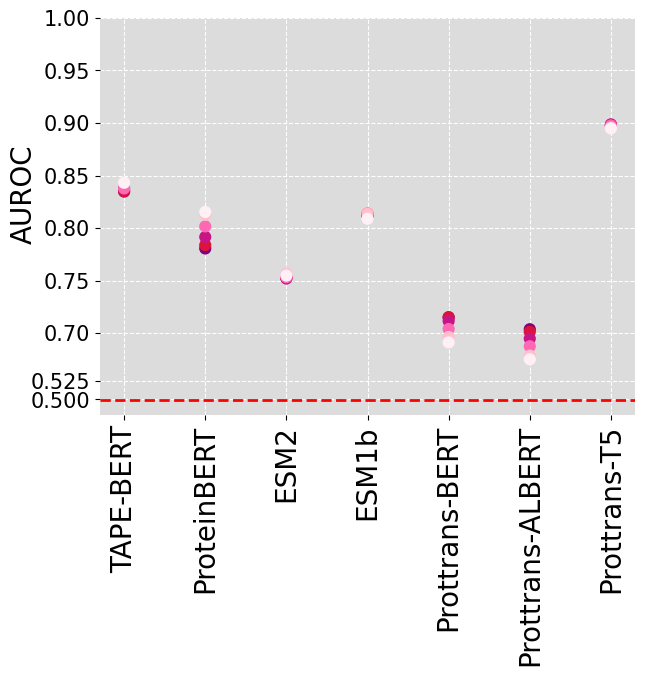

In [5]:
# for debugging, evaluate results for one set of data
data_name = "SCOP/ranking_results_random_repseq/" # SCOP, SCOPe
remote_homology_level = "superfamily"  # superfamily, fold
results_type = "non_weighted" # non_weighted, weighted
metric_name = "aurocs" # aurocs, auprcs, hit1s, hit10s
do_plotting(data_name, remote_homology_level, results_type, metric_name, save_plot=False)

SCOPe/ranking_results/ superfamily weighted aurocs


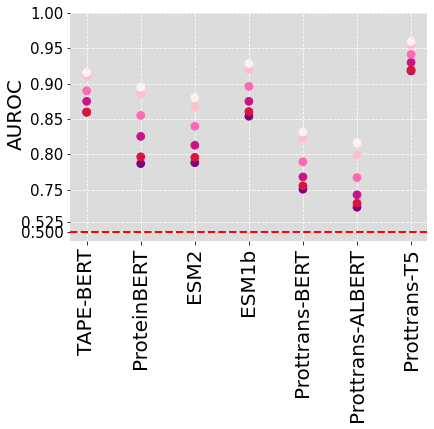

SCOPe/ranking_results/ superfamily weighted auprcs


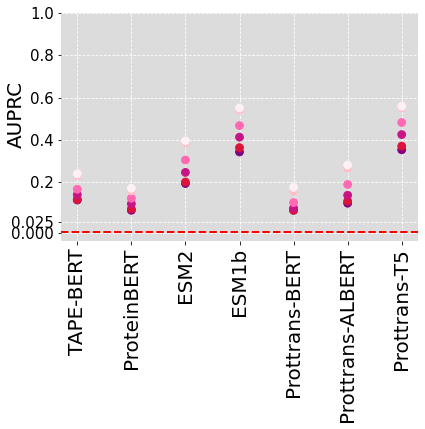

SCOPe/ranking_results/ superfamily weighted hit1s


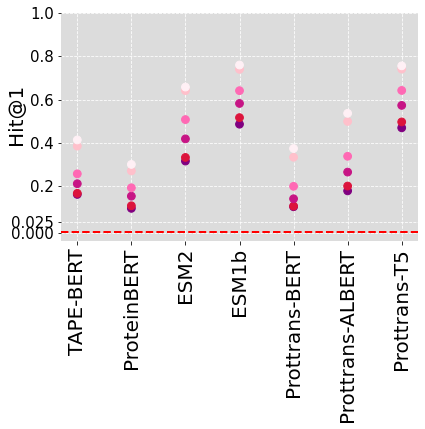

SCOPe/ranking_results/ superfamily weighted hit10s


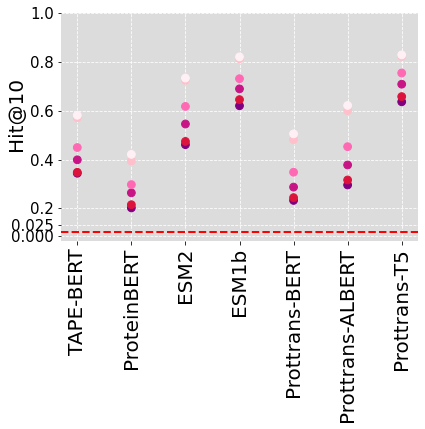

SCOPe/ranking_results/ fold weighted aurocs


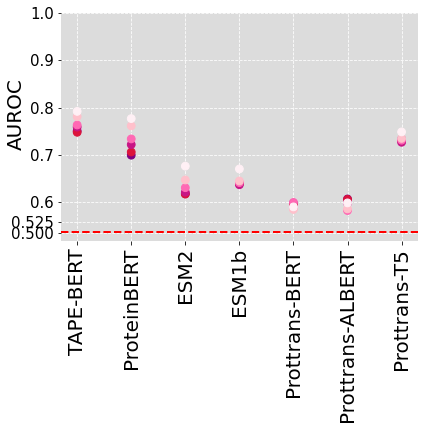

SCOPe/ranking_results/ fold weighted auprcs


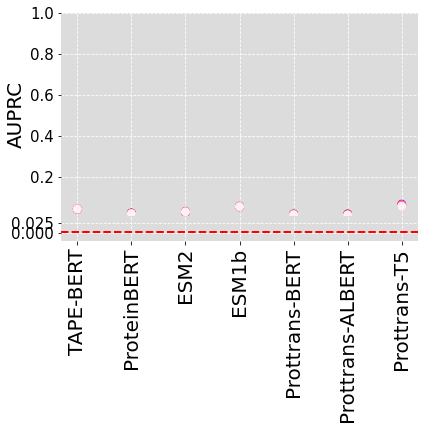

SCOPe/ranking_results/ fold weighted hit1s


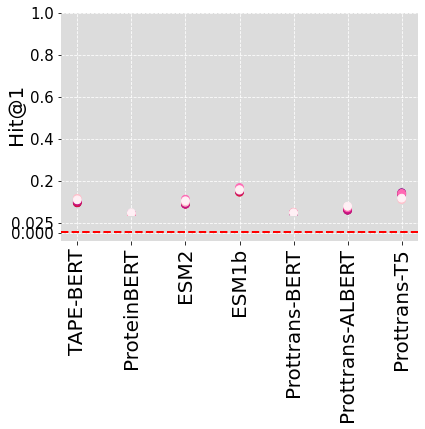

SCOPe/ranking_results/ fold weighted hit10s


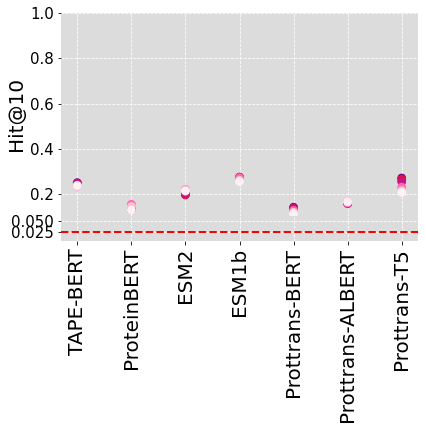

In [32]:
# to run for all combination of data
for data_name in ["SCOPe/ranking_results/"]: # "SCOPe"
    for remote_homology_level in ["superfamily", "fold"]:
        # for results_type in ["non_weighted", "weighted"]:
        for results_type in ["weighted"]:

            for metric_name in ["aurocs", "auprcs", "hit1s", "hit10s"]:
                print(data_name, remote_homology_level, results_type, metric_name)
                do_plotting(data_name, remote_homology_level, results_type, metric_name, save_plot=True)
    #             break
    #         break
    #     break
    # break

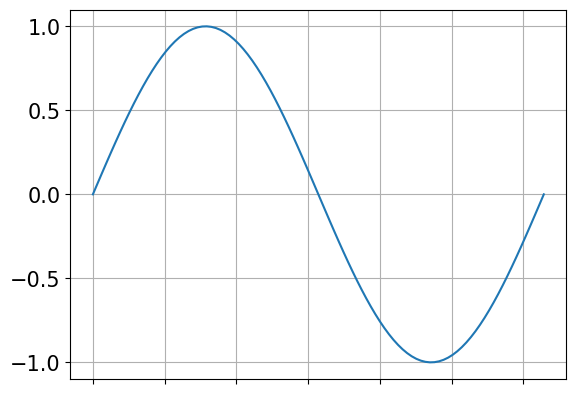

In [29]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 2*np.pi, 100)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x, np.sin(x))

ax.grid(True)
ax.set_xticklabels([])


plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../data/ranking_results/hhblits/superfamily/th_10/non_weighted_results.tsv'

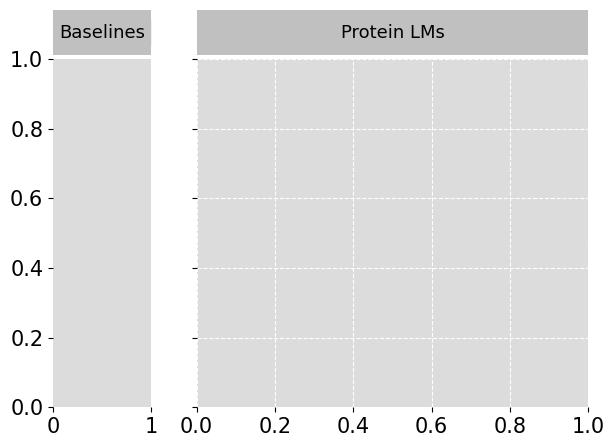

In [6]:
plt.rcParams['font.size'] = 15
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, width_ratios=[2, 8])
fig.tight_layout()


for ax in [ax1, ax2]:
    ax.set(facecolor="gainsboro")
    plt.grid(linestyle="--", c="white")
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

def add_title_spanning_width(ax, title_str):
    # setting the plot title to span the plot width
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size="13%", pad=0.04)
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.spines['top'].set_visible(False)
    cax.spines['right'].set_visible(False)
    cax.spines['bottom'].set_visible(False)
    cax.spines['left'].set_visible(False)
    cax.set_facecolor('silver')
    at = AnchoredText(title_str, loc=10, pad=0, borderpad=0,
                    prop=dict(backgroundcolor='silver', size=13, color='black'))
    cax.add_artist(at)

add_title_spanning_width(ax1, "Baselines")
add_title_spanning_width(ax2, "Protein LMs")

for model_idx, (model_name_key, model_name_value)  in enumerate(baseline_model_names_dict.items()):
    aurocs, auprcs, hit1s, hit10s = [], [], [], []
    for th in ths:
        results_df = pd.read_csv(home_dir+f"data/ranking_results/{model_name_key}/{remote_homology_level}/th_{th}/{results_type}_results.tsv", sep="\t")
        mean_perf = results_df[results_df["index"]=="mean"]
        auroc, auprc, hit1, hit10 = mean_perf["auroc"].values[0],  mean_perf["auprc"].values[0],  mean_perf["hit1"].values[0],  mean_perf["hit10"].values[0]
        # print(auroc, auprc, hit1, hit10)

        aurocs.append(auroc)
        auprcs.append(auprc)
        hit1s.append(hit1)
        hit10s.append(hit10)
    ax1.scatter([model_idx]*len(ths), aurocs, c=colors_for_ths, s=60)

ax1.set_ylabel("AUROC", fontsize=15)
model_names = list(baseline_model_names_dict.values())
ax1.set_xticks(ticks=range(len(baseline_model_names_dict)), labels=model_names, rotation='vertical')
plt.ylim(top=1.0)

for model_idx, (model_name_key, model_name_value)  in enumerate(model_names_dict.items()):
    aurocs, auprcs, hit1s, hit10s = [], [], [], []
    for th in ths:
        results_df = pd.read_csv(home_dir+f"data/ranking_results/{model_name_key}/{remote_homology_level}/th_{th}/{results_type}_results.tsv", sep="\t")
        mean_perf = results_df[results_df["index"]=="mean"]
        auroc, auprc, hit1, hit10 = mean_perf["auroc"].values[0],  mean_perf["auprc"].values[0],  mean_perf["hit1"].values[0],  mean_perf["hit10"].values[0]
        # print(auroc, auprc, hit1, hit10)

        aurocs.append(auroc)
        auprcs.append(auprc)
        hit1s.append(hit1)
        hit10s.append(hit10)

        
        # break
    ax2.scatter([model_idx]*len(ths), aurocs, c=colors_for_ths, s=60)
    # break

model_names = list(model_names_dict.values())
ax2.set_xticks(ticks=range(len(model_names_dict)), labels=model_names, rotation='vertical')

plt.ylim(top=1.0)
plt.show()